In [1]:
import tensorflow as tf
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check for GPU availability
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
except AttributeError as e:
    print(f"Error: {e}")

TensorFlow version: 2.16.2
Num GPUs Available:  1


In [2]:
from tensorflow.keras import mixed_precision

# Set the mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [3]:
import os 

def count_files_in_dir(directory):
    count = 0
    for root, dir, files in os.walk(directory):
        # Checking if the current dir we are walking through is labels (we skip) 
        if os.path.basename(root) == 'labels':
            continue
        count += len(files)
    return count

directories = ['train', 'test', 'valid']

for dir in directories:
    count = count_files_in_dir(dir)
    print(f'Number of images in {dir}: {count}')

Number of images in train: 1620
Number of images in test: 126
Number of images in valid: 284


In [4]:
import os
from PIL import Image

def collect_image_dimensions(directory):
    dimensions = set()  # Using a set to avoid duplicates
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):  # Add other extensions if needed
                file_path = os.path.join(root, file)
                with Image.open(file_path) as img:
                    dimensions.add(img.size)  # img.size returns a tuple (width, height)
    return dimensions

# Directories to search
directories = ['train', 'test', 'valid']

# Collect dimensions
all_dimensions = set()
for directory in directories:
    dimensions = collect_image_dimensions(directory)
    print(f'Dimensions in {directory}: {dimensions}')
    all_dimensions.update(dimensions)

# Print all unique dimensions across all directories
print('\n')
print(f'All unique dimensions: {all_dimensions}') 

Dimensions in train: {(640, 640)}
Dimensions in test: {(640, 640)}
Dimensions in valid: {(640, 640)}


All unique dimensions: {(640, 640)}


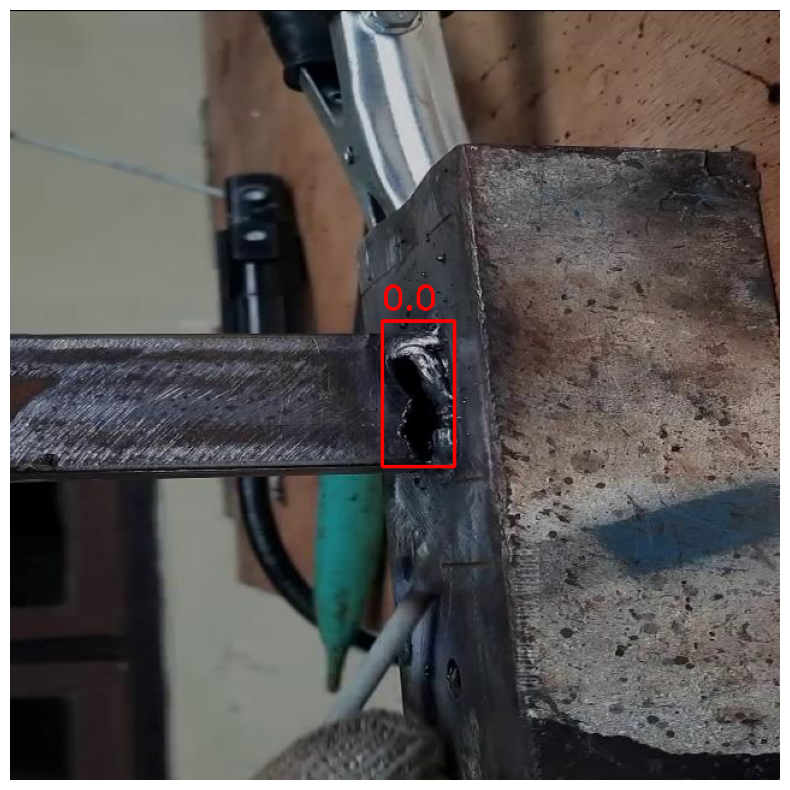

In [5]:
import cv2
import matplotlib.pyplot as plt

def plot_bounding_boxes(image_path, label_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load labels
    with open(label_path, 'r') as file:
        labels = file.readlines()
    
    height, width, _ = image.shape

    for label in labels:
        class_id, x_center, y_center, box_width, box_height = map(float, label.split())
        
        # Convert normalized coordinates to pixel values
        x_center *= width
        y_center *= height
        box_width *= width
        box_height *= height
        
        # Calculate bounding box coordinates
        x1 = int(x_center - (box_width / 2))
        y1 = int(y_center - (box_height / 2))
        x2 = int(x_center + (box_width / 2))
        y2 = int(y_center + (box_height / 2))
        
        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, f'{class_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Paths to the image and label file
image_path = 'train/images/bad_weld_vid204_jpeg.rf.5b5b6b044c4161c06aec6fd4cd78d33f.jpg'
label_path = 'train/labels/bad_weld_vid204_jpeg.rf.5b5b6b044c4161c06aec6fd4cd78d33f.txt'

# Plot the bounding boxes on the image
plot_bounding_boxes(image_path, label_path)

In [6]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class WeldDataset(Dataset):
    def __init__(self, image_dir, label_dir, img_size=640, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_height, orig_width, _ = image.shape

        # Resize image
        image = cv2.resize(image, (self.img_size, self.img_size))
        height, width, _ = image.shape

        boxes = []
        labels = []

        # Load labels
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file.readlines():
                    class_id, x_center, y_center, box_width, box_height = map(float, line.strip().split())
                    
                    # Convert normalized coordinates to pixel values based on the original image size
                    x_center *= orig_width
                    y_center *= orig_height
                    box_width *= orig_width
                    box_height *= orig_height

                    # Adjust coordinates based on the resized image size
                    x_center *= (width / orig_width)
                    y_center *= (height / orig_height)
                    box_width *= (width / orig_width)
                    box_height *= (height / orig_height)

                    x1 = int(x_center - (box_width / 2))
                    y1 = int(y_center - (box_height / 2))
                    x2 = int(x_center + (box_width / 2))
                    y2 = int(y_center + (box_height / 2))

                    boxes.append([x1, y1, x2, y2])
                    labels.append(int(class_id))

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Ensure image is a tensor
        if isinstance(image, np.ndarray):
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Convert to tensor and normalize to [0, 1]

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        return image, target

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [8]:
train_image_dir = '/Users/lukekottom/Desktop/ML_personal_projects/ml_personal_projects/welding_YOLO/train/images'
train_label_dir = '/Users/lukekottom/Desktop/ML_personal_projects/ml_personal_projects/welding_YOLO/train/labels'
valid_image_dir = '/Users/lukekottom/Desktop/ML_personal_projects/ml_personal_projects/welding_YOLO/valid/images'
valid_label_dir = '/Users/lukekottom/Desktop/ML_personal_projects/ml_personal_projects/welding_YOLO/valid/labels'
test_image_dir = '/Users/lukekottom/Desktop/ML_personal_projects/ml_personal_projects/welding_YOLO/test/images'
test_label_dir = '/Users/lukekottom/Desktop/ML_personal_projects/ml_personal_projects/welding_YOLO/test/labels'





In [9]:

# Initialize datasets
train_dataset = WeldDataset(train_image_dir, train_label_dir, transform=transform)
valid_dataset = WeldDataset(valid_image_dir, valid_label_dir, transform=transform)

# Create subsets of the datasets with only the first 50 images
train_subset = torch.utils.data.Subset(train_dataset, range(50))
valid_subset = torch.utils.data.Subset(valid_dataset, range(50))

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, 0)
    return images, targets

# Initialize data loaders
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
valid_loader = DataLoader(valid_subset, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Verify the data loading process
for images, targets in train_loader:
    print(images.shape)  # Should print [batch_size, 3, H, W]
    print(targets)  # Should print a list of dictionaries with 'boxes' and 'labels'
    break


torch.Size([8, 3, 640, 640])
[{'boxes': tensor([[  0., 290., 151., 455.],
        [197., 281., 383., 446.],
        [419., 293., 634., 449.],
        [147., 333., 197., 404.],
        [380., 387., 421., 427.]]), 'labels': tensor([1, 1, 1, 2, 2])}, {'boxes': tensor([[232., 159., 256., 518.],
        [109., 141., 128., 424.],
        [231., 154., 257., 524.],
        [427., 105., 470., 631.]]), 'labels': tensor([2, 1, 0, 1])}, {'boxes': tensor([[424.,  82., 577., 122.],
        [469., 553., 640., 604.],
        [426.,  82., 580., 129.],
        [446., 279., 634., 323.],
        [150., 219., 309., 262.],
        [ 57., 542., 278., 611.],
        [467., 554., 640., 605.]]), 'labels': tensor([2, 2, 0, 1, 1, 1, 0])}, {'boxes': tensor([[124., 306., 261., 522.]]), 'labels': tensor([1])}, {'boxes': tensor([[194., 236., 505., 379.]]), 'labels': tensor([1])}, {'boxes': tensor([[206., 314., 272., 350.]]), 'labels': tensor([1])}, {'boxes': tensor([[381.,  95., 527., 419.]]), 'labels': tensor([1])},

In [10]:
import yaml

# Load the YAML file
with open('/Users/lukekottom/Desktop/ML_personal_projects/ml_personal_projects/welding_YOLO/data.yaml') as file:
    config = yaml.safe_load(file)


nc = config['nc']
class_names = config['names']
print("Number of classes:", nc)
print("Class names:", class_names)

Number of classes: 3
Class names: ['Bad Weld', 'Good Weld', 'Defect']


In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, nc)

# Move the model to the appropriate device (GPU or CPU)
device = 'cpu'
model.to(device)

# Example forward pass
images, targets = next(iter(train_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# Perform a forward pass
model.train()
output = model(images, targets)  # During training
print(output)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'loss_classifier': tensor(0.8445, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0957, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1317, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0155, grad_fn=<DivBackward0>)}


In [12]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)        
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
    
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss}")

# Save the trained model
torch.save(model.state_dict(), 'weld_detection_model.pth')

  0%|          | 0/7 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [14]:

# Initialize the test dataset
test_dataset = WeldDataset(test_image_dir, test_label_dir, transform=transform)
# Initialize the test DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(image, boxes, labels, class_names):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy array for plotting

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, class_names[label], color='yellow', fontsize=12, backgroundcolor='black')
    
    plt.show()

# Define class names
class_names = ['Bad Weld', 'Good Weld', 'Defect']

# Load the trained model weights
model.load_state_dict(torch.load('weld_detection_model.pth'))
model.eval()  # Set the model to evaluation mode

# Run inference on the test set
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        outputs = model(images)

        for i, output in enumerate(outputs):
            print(f"Image {i+1} Predictions:")
            print("Boxes:", output['boxes'])
            print("Labels:", output['labels'])
            if len(output['boxes']) == 0:
                print("No boxes detected.")
            else:
                # Plot the image with bounding boxes
                plot_image_with_boxes(images[i], output['boxes'], output['labels'], class_names)

Image 1 Predictions:
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
No boxes detected.
Image 1 Predictions:
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
No boxes detected.
Image 1 Predictions:
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
No boxes detected.
Image 1 Predictions:
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
No boxes detected.
Image 1 Predictions:
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
No boxes detected.
Image 1 Predictions:
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
No boxes detected.
Image 1 Predictions:
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
No boxes detected.
Image 1 Predictions:
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
No boxes detected.
Image 1 Predictions:
Boxes: tensor([], size=(0, 4))
Labels: tensor([], dtype=torch.int64)
No boxes detected.
Image 1 Predictions

KeyboardInterrupt: 